# Session 13: Visualization

In [1]:

import parsl
from parsl import python_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

from ipyleaflet import Map, LocalTileLayer, WMSLayer, projections

from grouputils import initialize_rasterizer

Interactive plotting is an excellent tool to facilitate data exploration. A very popular tool for creating Interactive maps is [Leaflet](https://leafletjs.com/). Leaflet is a JavaScript library for mapping, which has wrappers in numerous languages including python (`ipyleaflet`).

In session 8 and 11, we created tiles at the maximum zoom level (z: 13). If you wanted to display all of this data on an interactive map, like a Leaflet map, it would be extremely slow to load because there is so much of it, and it's at such a high resolution. To show this data in a performant way on a map, we need to create lower resolution tiles, and they need to be in a web-accessible format (most browsers can't render GeoTIFF files, PNG is better.) - [Here is a good explanation](https://www.maptiler.com/google-maps-coordinates-tile-bounds-projection/)

Today, we will create web tiles and png images of those tiles at zoom levels from 1 to 13. This way, when we are zoomed out in the interactive map, the lower resolution zoom level 1 is loaded. Only when you zoom in, and the extent is smaller, will higher resolution levels load. This scaling of resolution by zoom level is what allows us to interact with the data in a performant way.

First, we'll set up the rasterizer as before.

In [2]:
iwp_rasterizer = initialize_rasterizer("/home/shares/example-pdg-data")

Here are the methods that we will use from the RasterTiler:

`parent_geotiffs_from_children`, which takes as an argument the set of tiles (geotiffs) that we produced yesterday, and produces parent tiles at the next zoom level up.

`webtiles_from_geotiffs` takes the set of geotiffs produced by `parent_geotiffs_from_children` and creates png webtiles from them.

Like the last session, we will run this code in batches.

In [3]:
# We'll also use the make_batch definition from Session 11 to create batches of
# GeoTIFF files to process.
def make_batch(items, batch_size):
    return [items[i:i + batch_size] for i in range(0, len(items), batch_size)]

## Creating parent tiles

To create lower resolution GeoTIFF files, we can combine high resolution GeoTIFFs then resample them so that we still have 256x256 pixel data. We will start with zoom level 13 (12 with 0 indexing), and run the `parent_geotiffs_from_children` method on each zoom level to generate the parent zoom level. Then we run it on the parent level to generate the grandparent level...and so on.

In [4]:
# Get each z-level of GeoTIFFs we need to create:
parent_zs = list(range(12, 0, -1))
print(f'Parent Zs: {parent_zs}')


Parent Zs: [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


Here is an example for how we can run this, without parsl, on a single zoom level.

In [5]:
parent_z = 12
batch_size = 50

# get a list of child paths from the parent zoom level
child_paths = iwp_rasterizer.tiles.get_filenames_from_dir(
    'geotiff',
    z=parent_z + 1)

# Make a list of all the parent tiles that will be created from the z+1 child
# tiles
parent_tiles = set()
for child_path in child_paths:
    parent_tile = iwp_rasterizer.tiles.get_parent_tile(child_path)
    parent_tiles.add(parent_tile)
parent_tiles = list(parent_tiles)

# Break all parent tiles at level z into batches
parent_tile_batches = make_batch(parent_tiles, batch_size)


for parent_tile_batch in parent_tile_batches:
    iwp_rasterizer.parent_geotiffs_from_children(parent_tile_batch)


In [ ]:
parent_tile_batches

## do the first thing

Now that we know how to do this for one zoom level, how would you write this out for all of the levels?

In what part of the code would you want to insert a parsl app to parallelize the process? What dependencies exist for this process to run correctly?

Once you have those questions answered, write a parsl app to parallelize generating the parent tiles.

In [9]:
# Generate parsl app for creating parent geotiffs from children
@python_app
def parent_geotiffs_from_children_parsl(parent_tile_batch, iwp_rasterizer):
    return iwp_rasterizer.parent_geotiffs_from_children(parent_tile_batch)

Next, set up your executor as we did yesterday.

In [10]:
# Set up Parsl executor
activate_env = 'workon scomp'
htex_local = Config(
    executors=[
        HighThroughputExecutor(
            max_workers=32,
            provider=LocalProvider(
                worker_init=activate_env
            )
        )
    ],
)
parsl.clear()
parsl.load(htex_local)

Then generate parent tiles at all zoom levels. Don't forget to shut down your executor!

In [11]:
# generate parent tiles at all zoom levels using the parsl app

batch_size = 200

for parent_z in parent_zs: 
    # get a list of child paths from the parent zoom level
    child_paths = iwp_rasterizer.tiles.get_filenames_from_dir(
        'geotiff',
        z=parent_z + 1)

    # Make a list of all the parent tiles that will be created from the z+1 child
    # tiles
    parent_tiles = set()
    for child_path in child_paths:
        parent_tile = iwp_rasterizer.tiles.get_parent_tile(child_path)
        parent_tiles.add(parent_tile)
    parent_tiles = list(parent_tiles)

    # Break all parent tiles at level z into batches
    parent_tile_batches = make_batch(parent_tiles, batch_size)

    app_futures = []
    for parent_tile_batch in parent_tile_batches:
        app_future = parent_geotiffs_from_children_parsl(parent_tile_batch, iwp_rasterizer)
        app_futures.append(app_future)

    done = [app_future.result() for app_future in app_futures]

htex_local.executors[0].shutdown()
parsl.clear()

In [13]:
parent_z

1

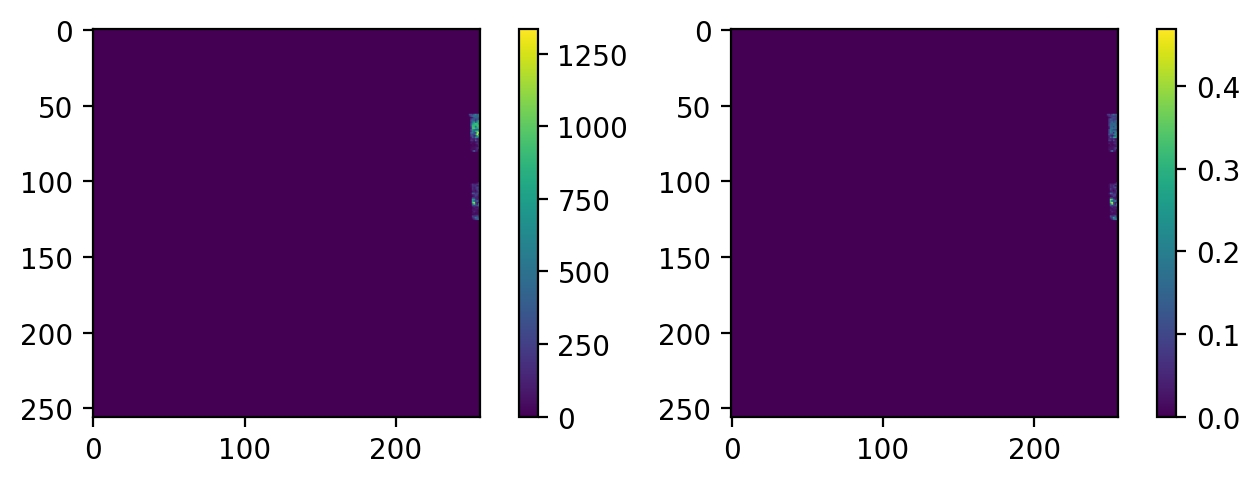

In [45]:
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

with rasterio.open('/home/vecchio/scalable-computing-examples/group-project/geotiff/WorldCRS84Quad/6/6/8.tif') as src:
    fig, ax = plt.subplots(1, 2, dpi=200)
    im0 = ax[0].imshow(src.read(1))
    im = rasterio.plot.show(src.read(1), ax=ax[0])
    divider = make_axes_locatable(ax[0])
    cax1 = divider.append_axes("right", size="5%", pad="10%")
    cb = fig.colorbar(im0, cax=cax1, orientation='vertical')

    im2 = ax[1].imshow(src.read(2))
    im3 = rasterio.plot.show(src.read(2), ax=ax[1])
    divider = make_axes_locatable(ax[1])
    cax2 = divider.append_axes("right", size="5%", pad="10%")
    cb = fig.colorbar(im2, cax=cax2, orientation='vertical')

    fig.tight_layout()


    #plt.imshow(src)

# Make webtiles

In the last step to create the webtiles for the map, we will use the `webtiles_from_geotiffs` method on all of the geotiffs we just created. First, we need to update our `iwp_rasterizer` config object using the `update_ranges` method, which will add the new zoom ranges we just created to the config information.

In [5]:
iwp_rasterizer.update_ranges()

Now we can get a list of files to create webtiles from, and run the `webtiles_from_geotiffs` over one.

In [6]:
geotiff_paths = iwp_rasterizer.tiles.get_filenames_from_dir('geotiff')
iwp_rasterizer.webtile_from_geotiff(geotiff_paths[0])

Tile(x=953, y=1081, z=13)

In [80]:
type(iwp_rasterizer.webtile_from_geotiff(geotiff_paths[0]))

morecantile.commons.Tile

In [61]:
len(geotiff_paths)

3139

Like we've done before, create a parsl app to create the webtiles in parallel. Since this process is incredibly fast, run it over batches of 200.

In [7]:
# create parsl app
# @python_app
# def create_web_tiles(geotiff_paths, rasterizer):
#     return rasterizer.webtiles_from_geotiffs(
#         geotiff_paths,
#          update_ranges=False,
#           recursive=False
#     )

# create parsl app
@python_app
def create_web_tiles(geotiff_paths, rasterizer):
    return rasterizer.webtiles_from_geotiffs(
        geotiff_paths, update_ranges=False)

In [8]:
# Set up Parsl executor
activate_env = 'workon scomp'
htex_local = Config(
    executors=[
        HighThroughputExecutor(
            max_workers=32,
            provider=LocalProvider(
                worker_init=activate_env
            )
        )
    ],
)
parsl.clear()
parsl.load(htex_local)

In [9]:
# run app over all of the geotiffs in batches of 200
batch_size_web_tiles = 200

geotiff_batches = make_batch(geotiff_paths, batch_size_web_tiles)

app_futures=[]

for batch in geotiff_batches:
    app_future = create_web_tiles(batch, iwp_rasterizer)
    app_futures.apppend(app_future)

done = [app_future.result() for app_future in app_futures]

htex_local.executors[0].shutdown()
parsl.clear()

AttributeError: 'list' object has no attribute 'apppend'

In [62]:
app_future

<AppFuture at 0x7f5ac7c2c070 state=finished raised NameError>

In [52]:
type(geotiff_batches)

list

## Make a map!

Now we are finally ready to explore these data using `ipyleaflet`. First, we have to set up a basemap layer to use. We use a set of WMS (Web Map Service) tiles provided by USGS. One reason we chose this set is it allows us to reproject the data into EPSG 4326, which is the projection our data are in. Other commonly used web tiles are in web mercator, which is not what our data are in.

In [10]:
wms = WMSLayer(
    url="https://basemap.nationalmap.gov:443/arcgis/services/USGSImageryTopo/MapServer/WmsServer",
    layers="0",
    format="image/png",
    transparent=True,
    min_zoom=0,
    crs=projections.EPSG4326
)

Now we can call the `Map` function from `ipyleaflet`, set up a default zoom and center, add the WMS layer and projection, and finally add our set of local tiles using the `add_layer` method. 

Note that the path you give to the `LocalTileLayer` function has variables for z, x, and y. If you look in the `geotiff` directory at the higher zoom levels, you'll wee that the directories and files are all named very regularly. This is so that they can be automatically handled by the `LocalTileLayer` function, and is a standard for how web tiles are served. The methods from the `rasterizer` class all handled this for us in our data processing.

In [11]:
m = Map(center=(66.5, -159.9),
        zoom=9,
        layers=(wms,),
        crs=projections.EPSG4326)

m.add_layer(LocalTileLayer(path='web_tiles/prop_pixel_covered_by_IWP/WorldCRS84Quad/{z}/{x}/{y}.png'));
# the x y and z are looking for zoom levles, directory levels etc. 
m

Map(center=[66.5, -159.9], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

## Bonus

Play around with [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/) and add whatever features you think might be useful, like a legend or markers.